In [1]:
import sys 
import os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import yaml
import argparse
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import logging
import time
from typing import Dict, Any
import matplotlib.pyplot as plt

from model.model_utils import get_model_from_configs, create_model_with_pretrained
from training.training_loops import get_training_loop_by_model_name
from training.visualize import get_full_image_and_prediction, compute_metrics
from sarpyx.utils.losses import get_loss_function
from training_script import load_config
from inference_script import create_test_dataloader
import matplotlib.pyplot as plt
import numpy as np

def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler("visualization.log"),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger()

In [2]:
def plot_intensity_histograms(orig_gt, orig_pred, gt, pred, figsize=(20, 12), bins=100):
    """
    Plot histograms of pixel intensities for original and processed data.
    Separate plots for real and imaginary components.
    """
    # Convert to numpy if needed
    if hasattr(orig_gt, 'numpy'):
        orig_gt = orig_gt.cpu().numpy()
    if hasattr(orig_pred, 'numpy'):
        orig_pred = orig_pred.cpu().numpy()
    if hasattr(gt, 'numpy'):
        gt = gt.cpu().numpy()
    if hasattr(pred, 'numpy'):
        pred = pred.cpu().numpy()
    
    # Create subplots: 2 rows (original vs processed) x 2 cols (real vs imaginary)
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    real_data_orig = np.concatenate([
        orig_gt.real.flatten(), orig_pred.real.flatten()
    ])
    real_data_denorm = np.concatenate([
        gt.real.flatten(), pred.real.flatten()
    ])
    imag_data_orig = np.concatenate([
        orig_gt.imag.flatten(), orig_pred.imag.flatten()
    ])
    imag_data_denorm = np.concatenate([
        gt.imag.flatten(), pred.imag.flatten()
    ])
    
    real_range_orig = (np.min(real_data_orig), np.max(real_data_orig))
    imag_range_orig = (np.min(imag_data_orig), np.max(imag_data_orig))
    real_range_denorm = (np.min(real_data_denorm), np.max(real_data_denorm))
    imag_range_denorm = (np.min(imag_data_denorm), np.max(imag_data_denorm))
    
    # Plot 1: Original data histograms - Real component
    axes[0, 0].hist(orig_gt.real.flatten(), bins=bins, alpha=0.7, label='Original GT (Real)', 
                    color='blue', density=True, range=real_range_orig)
    axes[0, 0].hist(orig_pred.real.flatten(), bins=bins, alpha=0.7, label='Original Pred (Real)', 
                    color='red', density=True, range=real_range_orig)
    axes[0, 0].set_title('Original Data - Real Component')
    axes[0, 0].set_xlabel('Pixel Intensity')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim(real_range_orig)
    
    # Plot 2: Original data histograms - Imaginary component
    axes[0, 1].hist(orig_gt.imag.flatten(), bins=bins, alpha=0.7, label='Original GT (Imag)', 
                    color='blue', density=True, range=imag_range_orig)
    axes[0, 1].hist(orig_pred.imag.flatten(), bins=bins, alpha=0.7, label='Original Pred (Imag)', 
                    color='red', density=True, range=imag_range_orig)
    axes[0, 1].set_title('Original Data - Imaginary Component')
    axes[0, 1].set_xlabel('Pixel Intensity')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim(imag_range_orig)
      # Explicitly set x-axis limits

    # Plot 3: Processed data histograms - Real component
    axes[1, 0].hist(gt.real.flatten(), bins=bins, alpha=0.7, label='Processed GT (Real)', 
                    color='green', density=True, range=real_range_denorm)
    axes[1, 0].hist(pred.real.flatten(), bins=bins, alpha=0.7, label='Processed Pred (Real)', 
                    color='orange', density=True, range=real_range_denorm)
    axes[1, 0].set_title('Processed Data - Real Component')
    axes[1, 0].set_xlabel('Pixel Intensity')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim(real_range_denorm)
    
    # Plot 4: Processed data histograms - Imaginary component
    axes[1, 1].hist(gt.imag.flatten(), bins=bins, alpha=0.7, label='Processed GT (Imag)', 
                    color='green', density=True, range=imag_range_denorm)
    axes[1, 1].hist(pred.imag.flatten(), bins=bins, alpha=0.7, label='Processed Pred (Imag)', 
                    color='orange', density=True, range=imag_range_denorm)
    axes[1, 1].set_title('Processed Data - Imaginary Component')
    axes[1, 1].set_xlabel('Pixel Intensity')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim(imag_range_denorm)
    
    # Add statistics text
    for i, (data_gt, data_pred, title_suffix) in enumerate([
        (orig_gt, orig_pred, "Original"),
        (gt, pred, "Processed")
    ]):
        for j, component in enumerate(['real', 'imag']):
            if component == 'real':
                gt_comp, pred_comp = data_gt.real, data_pred.real
            else:
                gt_comp, pred_comp = data_gt.imag, data_pred.imag
            
            # Calculate statistics
            gt_mean, gt_std = np.mean(gt_comp), np.std(gt_comp)
            pred_mean, pred_std = np.mean(pred_comp), np.std(pred_comp)
            
            # Add stats text box
            stats_text = f'GT: μ={gt_mean:.2f}, σ={gt_std:.2f}\nPred: μ={pred_mean:.2f}, σ={pred_std:.2f}'
            axes[i, j].text(0.02, 0.98, stats_text, transform=axes[i, j].transAxes, 
                           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("DETAILED STATISTICS")
    print("="*60)
    
    for data_name, data_gt, data_pred in [("Original", orig_gt, orig_pred), ("Processed", gt, pred)]:
        print(f"\n{data_name} Data:")
        print("-" * 30)
        
        for comp_name, gt_comp, pred_comp in [("Real", data_gt.real, data_pred.real), 
                                              ("Imaginary", data_gt.imag, data_pred.imag)]:
            print(f"\n{comp_name} Component:")
            print(f"  GT    - Mean: {np.mean(gt_comp):8.4f}, Std: {np.std(gt_comp):8.4f}, "
                  f"Min: {np.min(gt_comp):8.4f}, Max: {np.max(gt_comp):8.4f}")
            print(f"  Pred  - Mean: {np.mean(pred_comp):8.4f}, Std: {np.std(pred_comp):8.4f}, "
                  f"Min: {np.min(pred_comp):8.4f}, Max: {np.max(pred_comp):8.4f}")
            print(f"  Diff  - Mean: {np.mean(gt_comp - pred_comp):8.4f}, "
                  f"Std: {np.std(gt_comp - pred_comp):8.4f}")

2025-10-01 16:38:00,120 - INFO - Configuration Summary:
2025-10-01 16:38:00,121 - INFO -   Data directory: /Data/sar_focusing
2025-10-01 16:38:00,121 - INFO -   Level from: rc
2025-10-01 16:38:00,122 - INFO -   Level to: az
2025-10-01 16:38:00,122 - INFO -   Patch size: [10000, 1]
2025-10-01 16:38:00,123 - INFO -   Batch size: 32
2025-10-01 16:38:00,123 - INFO -   Save directory: ./visualizations
2025-10-01 16:38:00,124 - INFO - Creating test dataloader...


{'data_dir': '/Data/sar_focusing', 'model': {'name': 's4_ssm', 'dim_head': 1, 'input_dim': 2, 'model_dim': 64, 'state_dim': 540, 'output_dim': 1, 'num_layers': 6, 'dropout': 0.2, 'use_pos_encoding': True, 'complex_valued': True, 'use_selectivity': True, 'activation_function': 'gelu', 'dim': 64, 'depth': 6}, 'training': {'patience': 50, 'delta': 1e-05, 'weight_decay': 0.001, 'epochs': 300, 'lr': 0.0001, 'scheduler_type': 'cosine', 'loss_fn': 'complex_mse', 'save_dir': './results/s4_ssm_complex_results_mse_warmup', 'mode': 'parallel', 'warmup_epochs': 5, 'warmup_start_lr': 1e-05}, 'device': 'cuda', 'dataloader': {'data_dir': '/Data/sar_focusing', 'level_from': 'rc', 'level_to': 'az', 'num_workers': 0, 'patch_mode': 'rectangular', 'patch_size': [10000, 1], 'buffer': [1000, 1000], 'stride': [10000, 1], 'max_base_sample_size': [5000, 5000], 'shuffle_files': False, 'complex_valued': True, 'save_samples': False, 'backend': 'zarr', 'verbose': False, 'cache_size': 1000, 'online': True, 'concate

2025-10-01 16:38:03,119 - INFO - Created test dataloader with 157 batches
2025-10-01 16:38:03,120 - INFO - Dataset contains 5000 samples
2025-10-01 16:38:03,176 - INFO - Starting sample visualization...
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
2025-10-01 16:38:03,179 - INFO - 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
2025-10-01 16:38:03,194 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-10-01 16:38:03,195 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-10-01 16:38:03,196 - INFO - HPU available: False, using: 0 HPUs

Loading pretrained weights from: /Data/gdaga/sarpyx_new/sarpyx/training/../results/s4_ssm_results/model_best.pth
Successfully loaded 94 parameters
BASE SAVE DIR: ./visualizations
{'mse': 7859512.5, 'rmse': np.float64(2803.4822096813814), 'psnr_db': 41.23500061035156, 'ssim': 0.8805957247097562, 'amplitude_correlation': 0.4884245693683624, 'phase_mae_rad': 0.0, 'phase_rmse_rad': 0.0, 'phase_mae_deg': np.float64(0.0), 'phase_rmse_deg': np.float64(0.0), 'complex_coherence': 0.8158302307128906, 'phase_coherence': 0.96875, 'enl_reference': 0.0320928730070591, 'enl_predicted': 0.16720017790794373, 'enl_ratio': 5.2098850069037645, 'resolution_gain': 1.0}


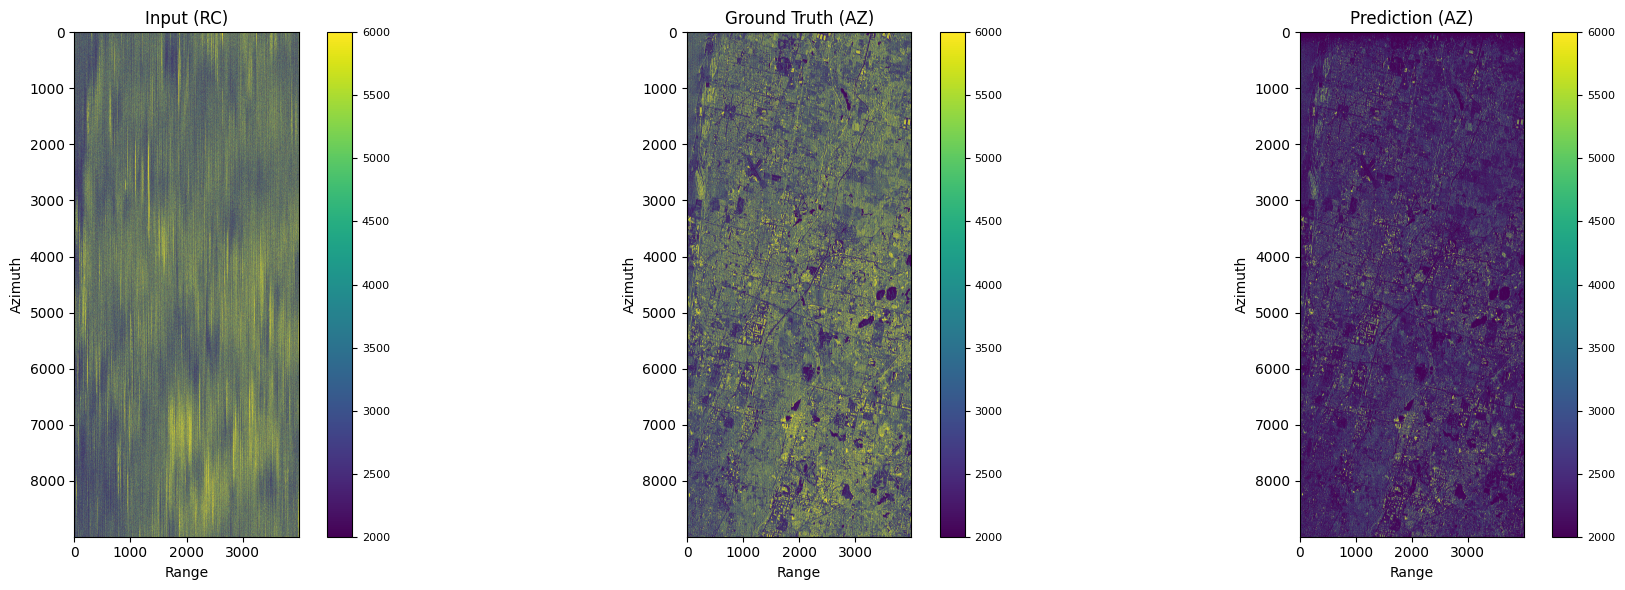

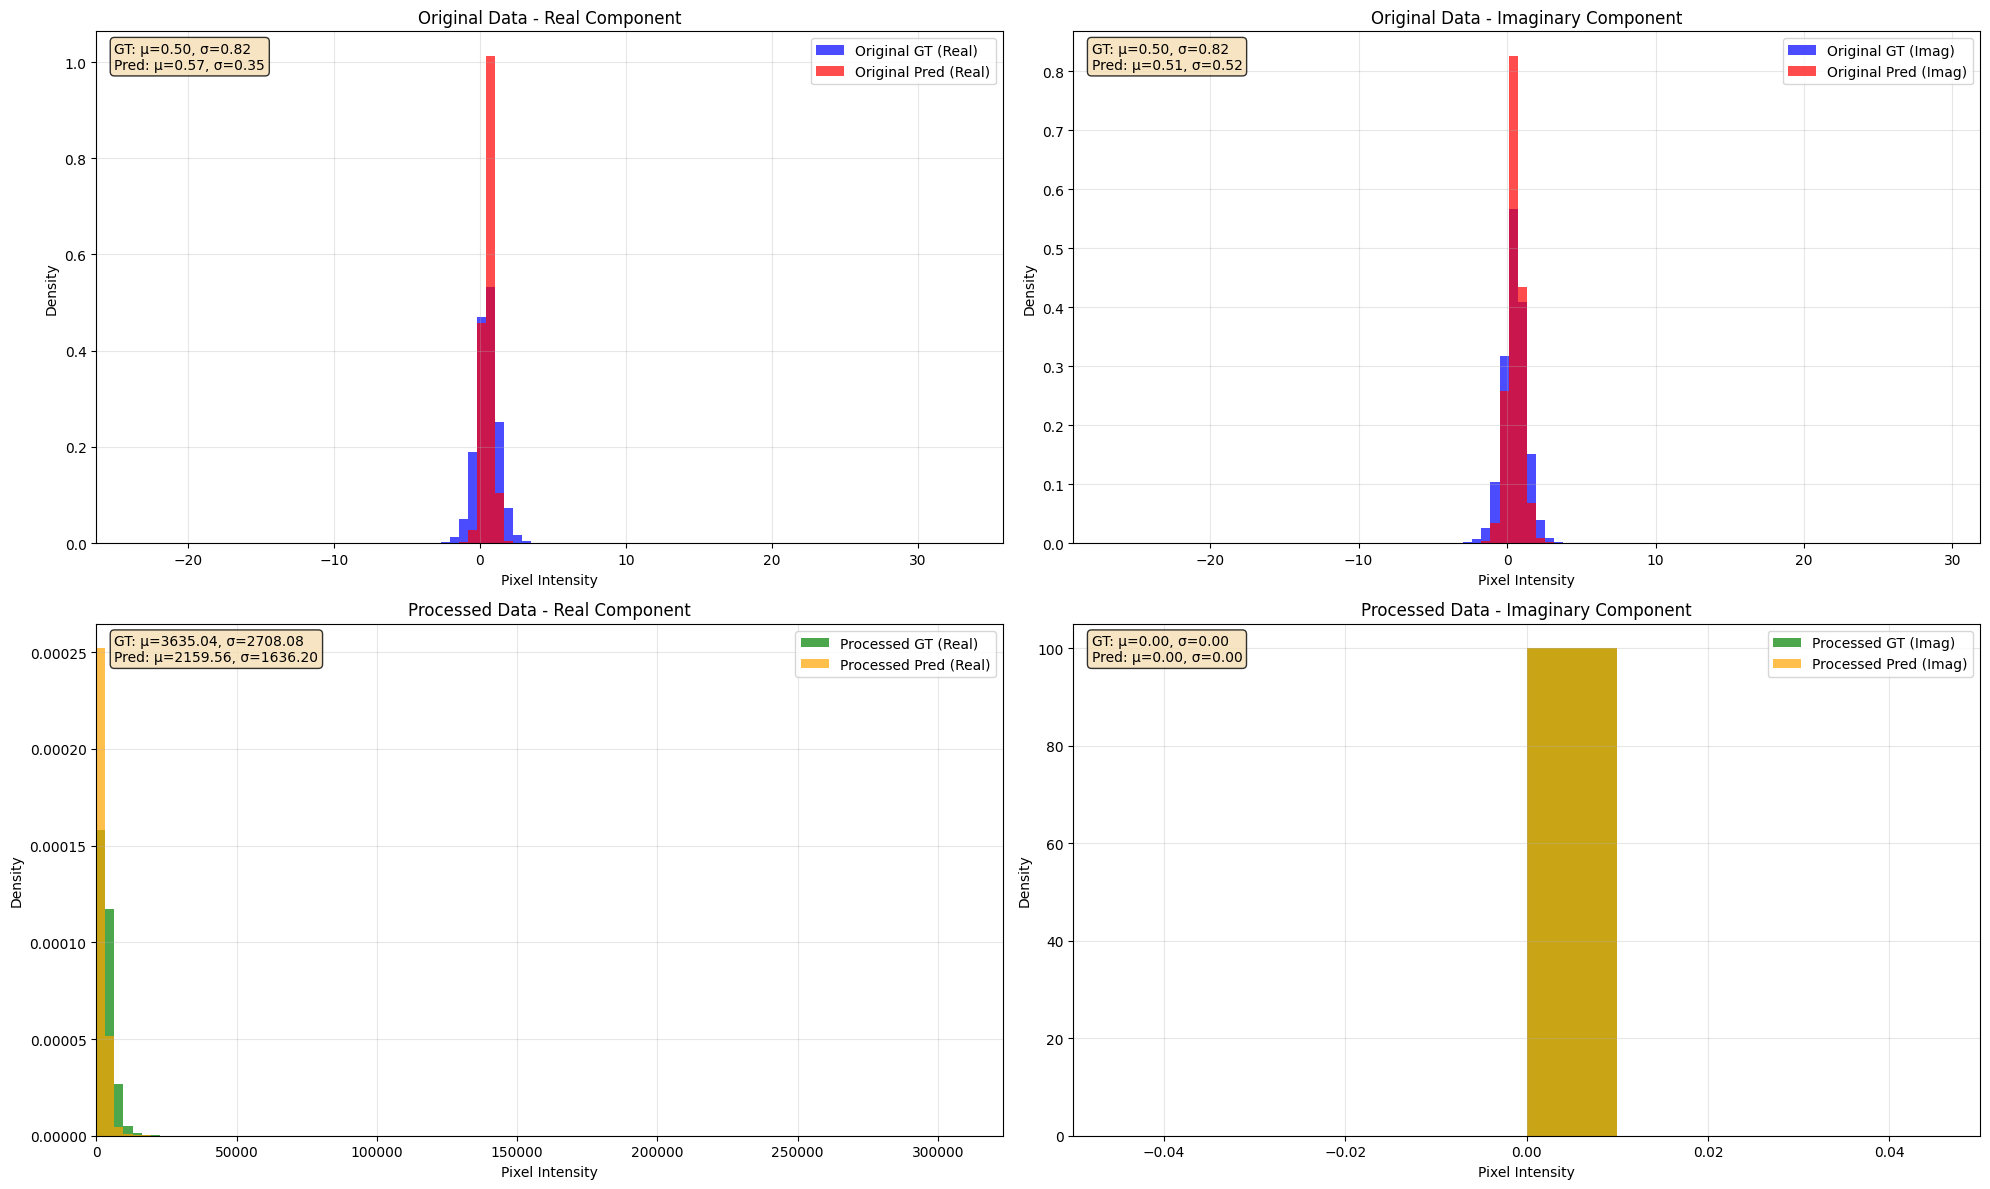


DETAILED STATISTICS

Original Data:
------------------------------

Real Component:
  GT    - Mean:   0.4999, Std:   0.8191, Min: -26.2849, Max:  35.8223
  Pred  - Mean:   0.5663, Std:   0.3509, Min:  -4.8444, Max:   5.8534
  Diff  - Mean:  -0.0664, Std:   0.7669

Imaginary Component:
  GT    - Mean:   0.5005, Std:   0.8242, Min: -29.2093, Max:  31.8582
  Pred  - Mean:   0.5067, Std:   0.5152, Min:  -6.0954, Max:   6.7896
  Diff  - Mean:  -0.0063, Std:   0.7933

Processed Data:
------------------------------

Real Component:
  GT    - Mean: 3635.0430, Std: 2708.0762, Min:   0.0000, Max: 323182.3438
  Pred  - Mean: 2159.5562, Std: 1636.1968, Min:   0.0000, Max: 33982.2500
  Diff  - Mean: 1475.4871, Std: 2383.7891

Imaginary Component:
  GT    - Mean:   0.0000, Std:   0.0000, Min:   0.0000, Max:   0.0000
  Pred  - Mean:   0.0000, Std:   0.0000, Min:   0.0000, Max:   0.0000


2025-10-01 16:41:47,156 - INFO - Visualization completed successfully!
2025-10-01 16:41:47,157 - INFO - Check the visualizations in: ./visualizations


  Diff  - Mean:   0.0000, Std:   0.0000


In [4]:
def display_inference_results(input_data, gt_data, pred_data, figsize=(20, 6), vminmax=(0, 1000), show: bool=True, save: bool=True, save_path: str="./visualizations"):
    """
    Display input, ground truth, and prediction in a 3-column grid.
    
    Args:
        input_data: Input data from the dataset
        gt_data: Ground truth data
        pred_data: Model prediction
        figsize: Figure size
        vminmax: Value range for visualization
    """
    # Convert tensors to numpy if needed
    if hasattr(input_data, 'numpy'):
        input_data = input_data.cpu().numpy()
    if hasattr(gt_data, 'numpy'):
        gt_data = gt_data.cpu().numpy()
    if hasattr(pred_data, 'numpy'):
        pred_data = pred_data.cpu().numpy()
    
    # Function to get magnitude visualization (similar to get_sample_visualization)
    def get_magnitude_vis(data, vminmax):
        if np.iscomplexobj(data):
            magnitude = np.abs(data)
        else:
            magnitude = data
        
        if vminmax == 'auto':
            vmin, vmax = np.percentile(magnitude, [2, 98])
        elif isinstance(vminmax, tuple):
            vmin, vmax = vminmax
        else:
            vmin, vmax = np.min(magnitude), np.max(magnitude)
        
        return magnitude, vmin, vmax
    
    # Prepare visualizations
    imgs = []
    
    # Input data
    img, vmin, vmax = get_magnitude_vis(input_data, vminmax)
    imgs.append({'name': 'Input (RC)', 'img': img, 'vmin': vmin, 'vmax': vmax})
    
    # Ground truth
    img, vmin, vmax = get_magnitude_vis(gt_data, vminmax)
    imgs.append({'name': 'Ground Truth (AZ)', 'img': img, 'vmin': vmin, 'vmax': vmax})
    
    # Prediction
    img, vmin, vmax = get_magnitude_vis(pred_data, vminmax)
    imgs.append({'name': 'Prediction (AZ)', 'img': img, 'vmin': vmin, 'vmax': vmax})
    
    # Create the plot
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    for i in range(3):
        im = axes[i].imshow(
            imgs[i]['img'],
            aspect='auto',
            cmap='viridis',
            vmin=imgs[i]['vmin'],
            vmax=imgs[i]['vmax']
        )
        
        axes[i].set_title(f"{imgs[i]['name']}")
        axes[i].set_xlabel('Range')
        axes[i].set_ylabel('Azimuth')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        
        # Set equal aspect ratio
        axes[i].set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.show()

args = argparse.Namespace(
    config="s4_ssm_complex.yaml",
    device="cuda", 
    batch_size=16,
    save_dir="./visualizations",
    mode="parallel",
    pretrained_path=os.path.join(os.getcwd(), '..', 'results', 's4_ssm_results','model_best.pth'), 
    learning_rate=1e-4, 
    num_epochs=50
)

# # Setup logging
logger = setup_logging()
#logger.info(f"Starting visualization with config: {args.config}")

# Load configuration
config = load_config(Path(args.config), args)

# Extract configurations
dataloader_cfg = config['dataloader']
training_cfg = config.get('training', {})

# Override save directory
save_dir = args.save_dir or training_cfg.get('save_dir', './visualizations')

# Log configuration summary
logger.info("Configuration Summary:")
logger.info(f"  Data directory: {dataloader_cfg.get('data_dir', 'Not specified')}")
logger.info(f"  Level from: {dataloader_cfg.get('level_from', 'rc')}")
logger.info(f"  Level to: {dataloader_cfg.get('level_to', 'az')}")
logger.info(f"  Patch size: {dataloader_cfg.get('patch_size', [1000, 1])}")
logger.info(f"  Batch size: {dataloader_cfg.get('test', {}).get('batch_size', 'Not specified')}")
logger.info(f"  Save directory: {save_dir}")

# Create test dataloader
logger.info("Creating test dataloader...")
try:
    test_loader = create_test_dataloader(dataloader_cfg)
    logger.info(f"Created test dataloader with {len(test_loader)} batches")
    logger.info(f"Dataset contains {len(test_loader.dataset)} samples")
except Exception as e:
    logger.error(f"Failed to create test dataloader: {str(e)}")
    raise

try:
    model = create_model_with_pretrained(config['model'], pretrained_path=args.pretrained_path, device=args.device)
except Exception as e:
    logger.error(f"Failed to load model: {str(e)}")
    raise

# Visualize samples
logger.info("Starting sample visualization...")
try:
    inference_fn = get_training_loop_by_model_name("ssm", train_loader=test_loader, val_loader=test_loader, test_loader=test_loader, model=model, save_dir=save_dir, mode=args.mode, loss_fn_name="mse")[0].forward
    gt, pred, input, orig_gt, orig_pred = get_full_image_and_prediction(
        dataloader=test_loader,
        show_window=((1000, 1000), (10000, 5000)),
        zfile=0,
        inference_fn=inference_fn,
        return_input=True, 
        return_original=True,
        device="cuda", 
        vminmax=(2000, 6000)
    )
    print(compute_metrics(gt, pred))
    display_inference_results(
        input_data=input,
        gt_data=gt,
        pred_data=pred,
        figsize=(20, 6),
        vminmax=(2000, 6000),  # Adjust this range based on your data, 
        show=True, 
        save=False
    )
    plot_intensity_histograms(orig_gt[..., 0], orig_pred, gt, pred, figsize=(20, 12), bins=100)
    logger.info("Visualization completed successfully!")
    logger.info(f"Check the visualizations in: {save_dir}")
    
except Exception as e:
    logger.error(f"Visualization failed with error: {str(e)}")
    raise